# <a id='toc1_'></a>[컴퓨터비전 중간고사 대체 프로젝트](#toc0_)



**Table of contents**<a id='toc0_'></a>    
- [컴퓨터비전 중간고사 대체 프로젝트](#toc1_)    
- [Tensorflow](#toc2_)    
  - [데이터 준비 및 탐색](#toc2_1_)    
  - [데이터 준비 및 전처리](#toc2_2_)    
  - [모델 구현 및 학습 함수 정의](#toc2_3_)    
  - [CNN 모델 구현 (Scratch)](#toc2_4_)    
  - [다양한 Activation 함수와 Optimizer 테스트](#toc2_5_)    
  - [ResNet50을 활용 Transfer Learning](#toc2_6_)    
  - [VGG16을 활용한 Transfer Learning](#toc2_7_)    
  - [DenseNet121을 활용한 Transfer Learning](#toc2_8_)    
  - [EfficientNetB0을 활용한 Transfer Learning](#toc2_9_)    
  - [MobileNetV2를 활용한 Transfer Learning](#toc2_10_)    
  - [Fine-Tuning을 통한 성능 향상 (최고 성능 모델)](#toc2_11_)    
  - [모델 성능 비교 및 결과 정리](#toc2_12_)    
- [Pytorch](#toc3_)    
  - [PyTorch CNN 모델 구현](#toc3_1_)    
  - [PyTorch ResNet50 Transfer Learning](#toc3_2_)    
  - [PyTorch Transfer Learning](#toc3_3_)    
- [결론](#toc4_)    
  - [결과 시각화](#toc4_1_)    
  - [참고문헌](#toc4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Tensorflow](#toc0_)

## <a id='toc2_1_'></a>[데이터 준비 및 탐색](#toc0_)

In [57]:
# 필요한 라이브러리 임포트
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from PIL import Image
import random
from tqdm.notebook import tqdm

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# HEIC 파일 처리를 위한 설정 (선택적)
try:
    from pillow_heif import register_heif_opener
    register_heif_opener()
    print("HEIC 이미지 지원 활성화")
except ImportError:
    print("HEIC 이미지 지원 비활성화 - 일부 이미지를 불러오지 못할 수 있습니다.")

# matplotlib 한글 설정
import matplotlib.font_manager as fm

# macOS 환경에서 한글 폰트 설정
if os.name == 'posix':  # macOS인 경우
    plt.rc('font', family='AppleGothic')
else:  # Windows인 경우
    plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False


HEIC 이미지 지원 활성화


In [58]:
# 랜덤 시드 설정
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# GPU 사용 여부 확인
print("TensorFlow 버전:", tf.__version__)
print("GPU 사용 가능 여부:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow 버전: 2.19.0
GPU 사용 가능 여부: False


In [59]:
# 데이터 경로 설정
DATA_DIR = 'data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# 이미지 사이즈 및 배치 사이즈 설정
IMG_SIZE = 224
BATCH_SIZE = 32

# 클래스 목록 확인
classes = sorted(os.listdir(TRAIN_DIR))
print(f"클래스 목록: {classes}")
print(f"클래스 수: {len(classes)}")

클래스 목록: ['1', '10-1', '10-2', '2', '3', '4', '5', '6', '7', '8', '9']
클래스 수: 11


In [60]:
# 이미지 로딩 함수 정의
def load_image(img_path):
    try:
        img = Image.open(img_path).convert('RGB')
        return np.array(img)
    except Exception as e:
        print(f"이미지 로딩 실패: {img_path} - {e}")
        return np.zeros((100, 100, 3), dtype=np.uint8)  # 실패 시 검은색 이미지 반환

# 일반 이미지 형식만 필터링 (선택적)
def is_valid_image(filename):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    ext = os.path.splitext(filename.lower())[1]
    return ext in valid_extensions

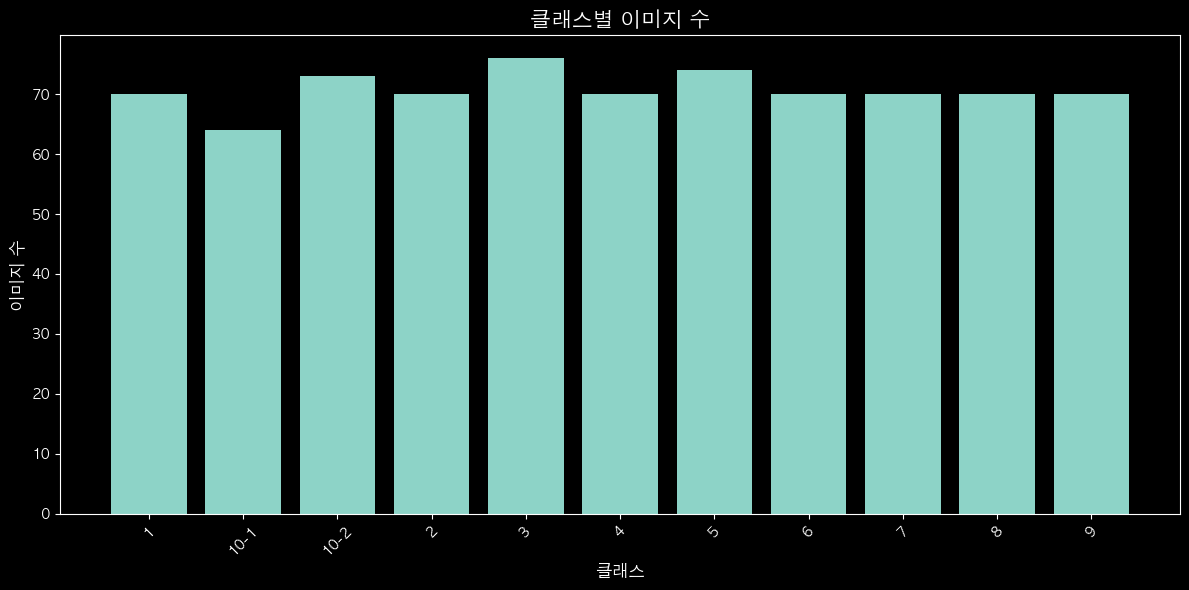

In [61]:
# 각 클래스별 이미지 수 확인
class_counts = {}
for cls in classes:
    class_counts[cls] = len(os.listdir(os.path.join(TRAIN_DIR, cls)))
    
# 데이터 분포 시각화
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('클래스별 이미지 수', fontsize=15)
plt.xlabel('클래스', fontsize=12)
plt.ylabel('이미지 수', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

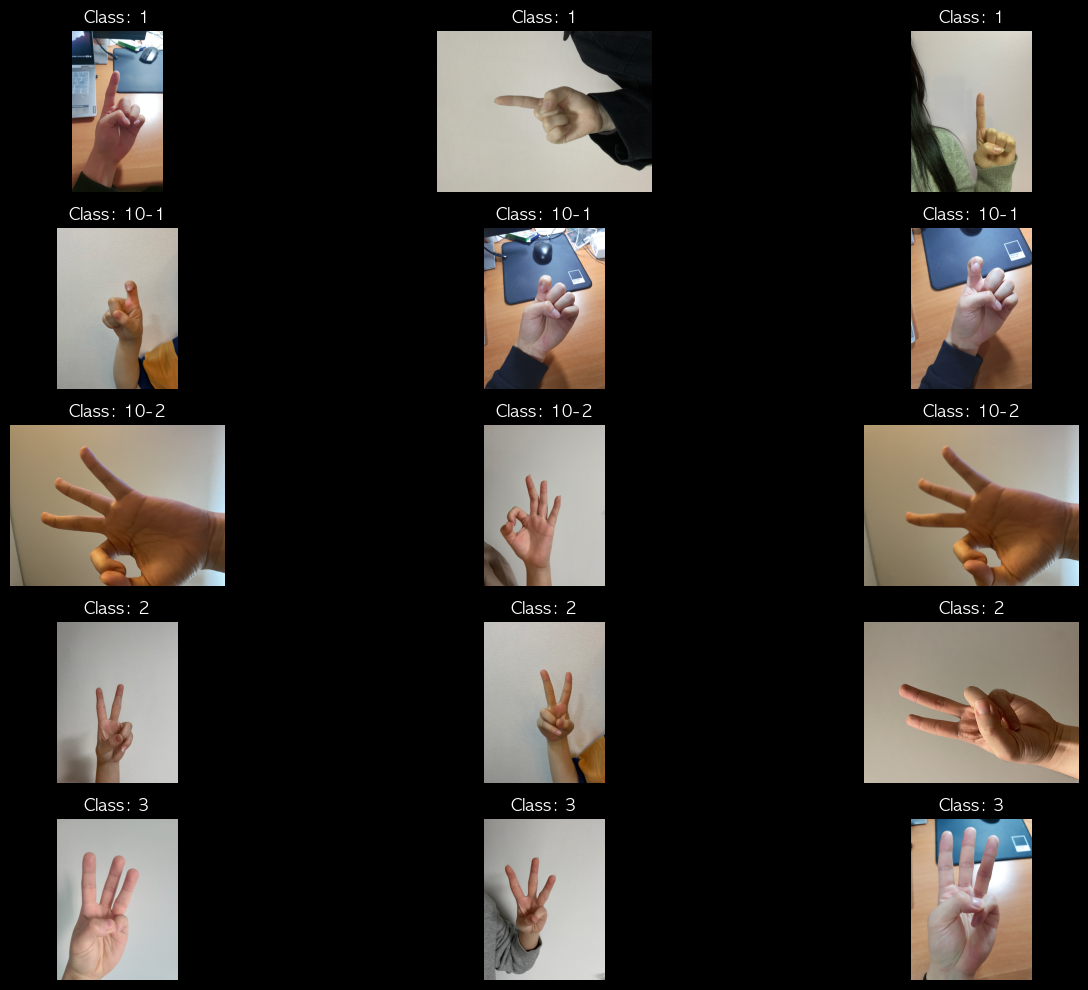

In [ ]:
# 샘플 이미지 시각화
plt.figure(figsize=(15, 10))
for i, cls in enumerate(classes[:5]):  # 처음 5개 클래스만 표시
    class_path = os.path.join(TRAIN_DIR, cls)
    
    # 일반 이미지 형식만 필터링
    all_images = [f for f in os.listdir(class_path) if is_valid_image(f)]
    if len(all_images) < 3:
        # 필터링된 이미지가 적으면 모든 이미지 시도
        all_images = os.listdir(class_path)
    
    sample_images = all_images[:3]  # 각 클래스당 3개 이미지
    
    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        img = load_image(img_path)
        plt.subplot(5, 3, i*3 + j + 1)
        plt.imshow(img)
        plt.title(f"Class: {cls}")
        plt.axis('off')
        
plt.tight_layout()
plt.show()

## <a id='toc2_2_'></a>[데이터 준비 및 전처리](#toc0_)

In [ ]:
# 데이터 증강 및 전처리 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 검증 데이터 분리
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 학습 데이터 생성기
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

# 검증 데이터 생성기
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

# 테스트 데이터 생성기
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 클래스 인덱스 매핑 확인
class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}
print("\n클래스 인덱스:")
for class_name, idx in class_indices.items():
    print(f"{class_name}: {idx}")

Found 588 images belonging to 11 classes.
Found 142 images belonging to 11 classes.
Found 34 images belonging to 11 classes.

클래스 인덱스:
1: 0
10-1: 1
10-2: 2
2: 3
3: 4
4: 5
5: 6
6: 7
7: 8
8: 9
9: 10


## <a id='toc2_3_'></a>[모델 구현 및 학습 함수 정의](#toc0_)

In [ ]:
# 모델 학습/평가 시각화 함수
def plot_history(history, model_name):
    # 정확도 및 손실 그래프 시각화
    plt.figure(figsize=(12, 5))
    
    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    
    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy', fontsize=15)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 모델 학습 및 평가 함수
def train_and_evaluate_model(model, model_name, epochs=20):
    # 콜백 함수 설정
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]
    
    # 모델 학습
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    
    # 테스트 셋 평가
    test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
    print(f"\n{model_name} - 테스트 정확도: {test_acc:.4f}")
    
    # 학습 결과 시각화
    plot_history(history, model_name)
    
    return history, test_acc

## <a id='toc2_4_'></a>[CNN 모델 구현 (Scratch)](#toc0_)

In [65]:
def create_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(classes)):
    model = models.Sequential([
        # 첫 번째 컨볼루션 블록
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        # 두 번째 컨볼루션 블록
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        # 세 번째 컨볼루션 블록
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        # 네 번째 컨볼루션 블록
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        # 분류기
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # 모델 컴파일
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [66]:
# 사용자 정의 CNN 모델 생성
custom_cnn = create_custom_cnn()
custom_cnn.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,874,411 (102.52 MB)

 Trainable params: 26,871,467 (102.51 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.1190 - loss: 3.4332 - val_accuracy: 0.1016 - val_loss: 3.1862 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.4167 - loss: 2.4156 - val_accuracy: 0.1016 - val_loss: 3.2610 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.1348 - loss: 3.0676 - val_accuracy: 0.0938 - val_loss: 4.3604 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.0833 - loss: 3.3259 - val_accuracy: 0.0938 - val_loss: 4.5310 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.1927 - loss: 2.8683 - val_accuracy: 0.0938 - val_loss: 3.3988 - learning_rate: 2.0000e-04
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.2188 - loss: 2.6885 - val_accuracy: 0.0938 - val_loss: 3.4119 - learning_rate: 2.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 4.4812

Custom CNN 

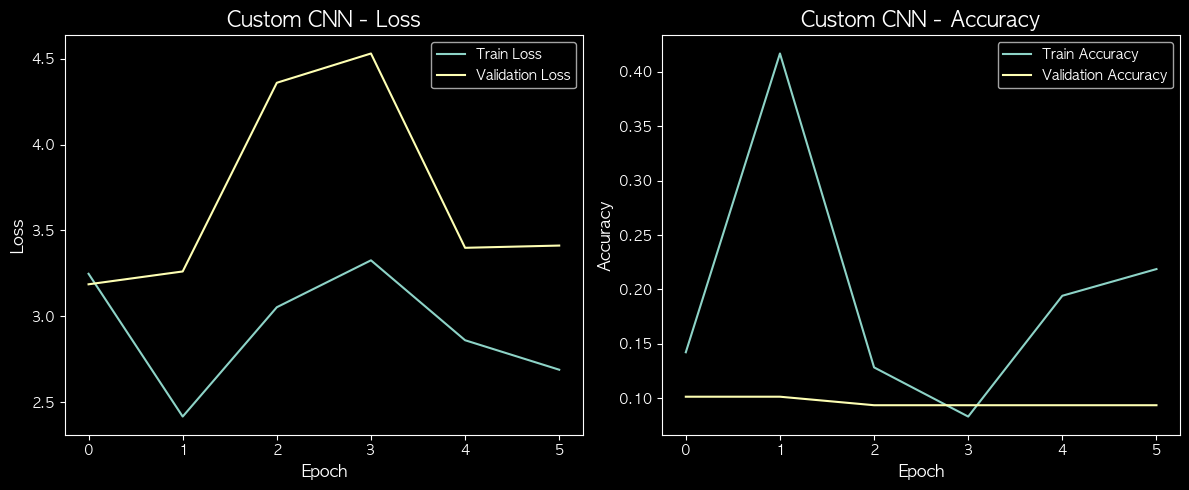

In [67]:
# 사용자 정의 CNN 모델 학습 및 평가
custom_cnn_history, custom_cnn_acc = train_and_evaluate_model(custom_cnn, 'Custom CNN')

In [ ]:
custom_cnn_acc

0.0

## <a id='toc2_5_'></a>[다양한 Activation 함수와 Optimizer 테스트](#toc0_)

In [12]:
# 다양한 활성화 함수와 옵티마이저를 사용한 CNN 모델
def create_custom_cnn_v2(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(classes), 
                        activation='selu', optimizer='rmsprop'):
    model = models.Sequential([
        # 첫 번째 컨볼루션 블록
        layers.Conv2D(32, (3, 3), padding='same', activation=activation, input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation=activation),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        # 두 번째 컨볼루션 블록
        layers.Conv2D(64, (3, 3), padding='same', activation=activation),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation=activation),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        # 세 번째 컨볼루션 블록
        layers.Conv2D(128, (3, 3), padding='same', activation=activation),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation=activation),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        # 분류기
        layers.Flatten(),
        layers.Dense(512, activation=activation),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # 옵티마이저 설정
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=0.001)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
    else:
        opt = optimizer
    
    # 모델 컴파일
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.1141 - loss: 4.3185 - val_accuracy: 0.1016 - val_loss: 49.9669 - learning_rate: 0.0010
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.0938 - loss: 3.8354 - val_accuracy: 0.1172 - val_loss: 53.9307 - learning_rate: 0.0010
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.1265 - loss: 3.4860 - val_accuracy: 0.0625 - val_loss: 6.9226 - learning_rate: 0.0010
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.2188 - loss: 3.0553 - val_accuracy: 0.0547 - val_loss: 6.9484 - learning_rate: 0.0010
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1463 - loss: 3.2747 - val_accuracy: 0.0078 - val_loss: 9.9081 - learning_rate: 0.0010
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.1250 - loss: 3.2606 - val_accuracy: 0.0000e+00 - val_loss: 6.6090 - learning_rate: 0.0010
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1760 - loss: 3.0878 - va

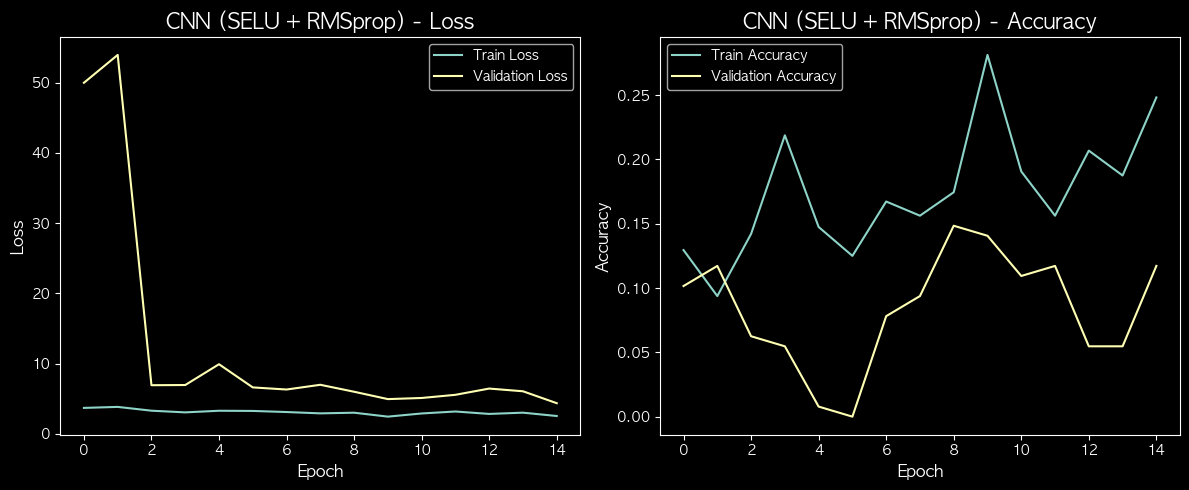

In [13]:
# SELU 활성화 함수와 RMSprop 옵티마이저 사용 모델
cnn_selu_rmsprop = create_custom_cnn_v2(activation='selu', optimizer='rmsprop')
cnn_selu_rmsprop_history, cnn_selu_rmsprop_acc = train_and_evaluate_model(
    cnn_selu_rmsprop, 'CNN (SELU + RMSprop)', epochs=15
)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.0895 - loss: 3.7514 - val_accuracy: 0.0625 - val_loss: 2.5495 - learning_rate: 0.0010
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.1562 - loss: 3.3895 - val_accuracy: 0.1016 - val_loss: 2.5624 - learning_rate: 0.0010
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2033 - loss: 3.4042 - val_accuracy: 0.1094 - val_loss: 2.9418 - learning_rate: 0.0010
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.3125 - loss: 2.5943 - val_accuracy: 0.1016 - val_loss: 2.9476 - learning_rate: 0.0010
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.1924 - loss: 2.9291 - val_accuracy: 0.1094 - val_loss: 3.4870 - learning_rate: 2.0000e-04
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.4062 - loss: 1.9955 - val_accuracy: 0.1094 - val_loss: 3.5011 - learning_rate: 2.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 3.2600

CNN (LeakyR

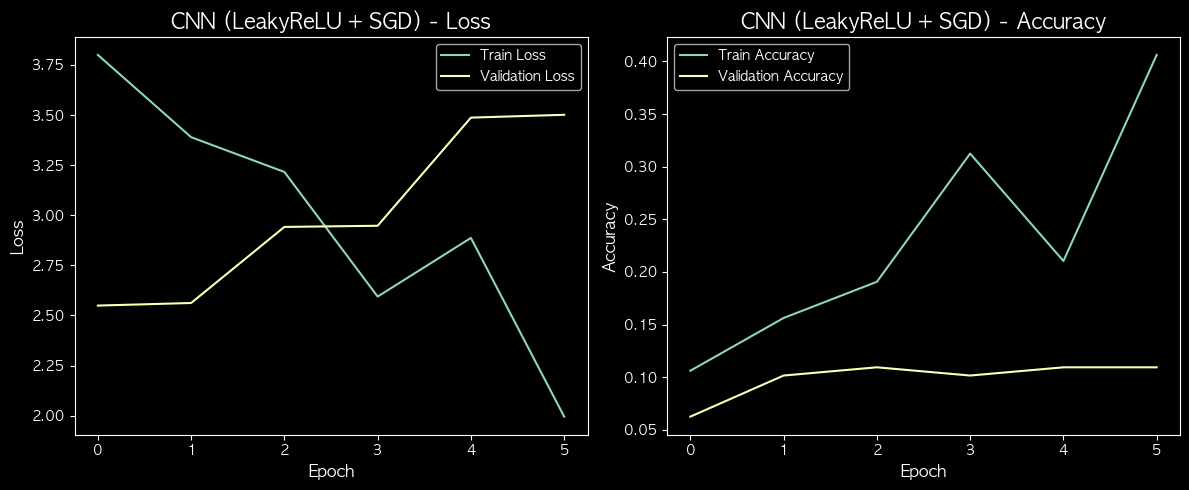

In [ ]:
# LeakyReLU 활성화 함수와 SGD 옵티마이저 사용 모델
cnn_leakyrelu_sgd = create_custom_cnn_v2(
    activation=layers.LeakyReLU(alpha=0.1), optimizer='sgd'
)
cnn_leakyrelu_sgd_history, cnn_leakyrelu_sgd_acc = train_and_evaluate_model(
    cnn_leakyrelu_sgd, 'CNN (LeakyReLU + SGD)', epochs=15
)

## <a id='toc2_6_'></a>[ResNet50을 활용 Transfer Learning](#toc0_)

In [15]:
def create_transfer_model(base_model_type, input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(classes)):
    # 베이스 모델 정의
    if base_model_type == 'ResNet50':
        base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_type == 'VGG16':
        base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_type == 'DenseNet121':
        base_model = applications.DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_type == 'EfficientNetB0':
        base_model = applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_type == 'MobileNetV2':
        base_model = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"지원하지 않는 베이스 모델 타입: {base_model_type}")
    
    # 특성 추출을 위해 베이스 모델 동결
    base_model.trainable = False
    
    # 분류 헤드 구성
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # 모델 컴파일
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [16]:
# ResNet50 Transfer Learning 모델 생성
resnet_model = create_transfer_model('ResNet50')
resnet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,116,107 (92.00 MB)

 Trainable params: 527,883 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1369 - loss: 2.5316 - val_accuracy: 0.0859 - val_loss: 2.5761 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.2812 - loss: 2.3889 - val_accuracy: 0.1016 - val_loss: 2.5610 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1467 - loss: 2.4250 - val_accuracy: 0.1016 - val_loss: 2.6382 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.1250 - loss: 2.1484 - val_accuracy: 0.1016 - val_loss: 2.6260 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2040 - loss: 2.3300 - val_accuracy: 0.1016 - val_loss: 2.5171 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.3125 - loss: 2.0933 - val_accuracy: 0.1016 - val_loss: 2.5135 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.1848 - loss: 2.2218 - val_accu

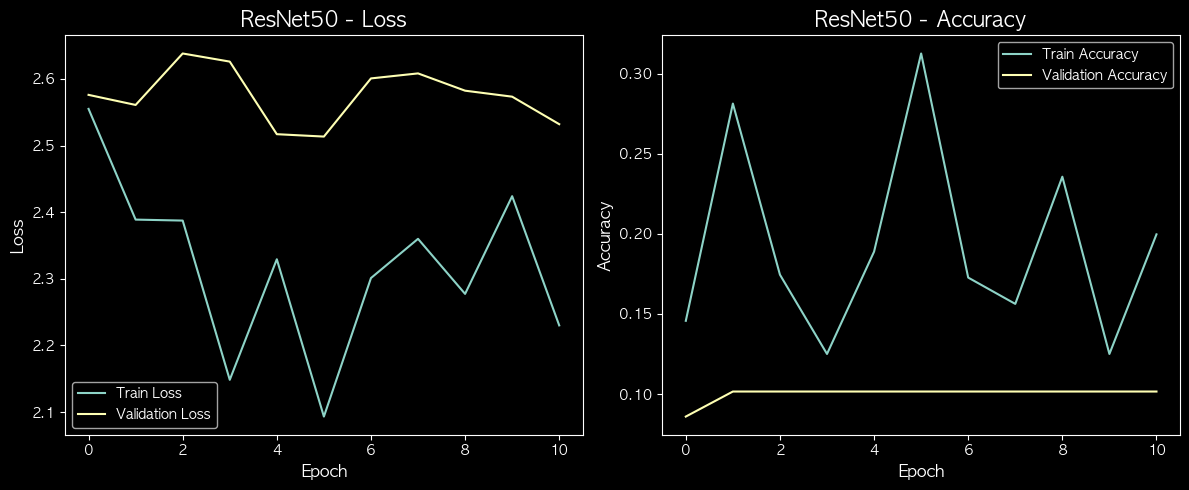

In [ ]:
# ResNet50 Transfer Learning 모델 학습 및 평가
resnet_history, resnet_acc = train_and_evaluate_model(resnet_model, 'ResNet50')

## <a id='toc2_7_'></a>[VGG16을 활용한 Transfer Learning](#toc0_)

In [18]:
# VGG16 Transfer Learning 모델 생성
vgg_model = create_transfer_model('VGG16')
vgg_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,867 (56.65 MB)

 Trainable params: 134,667 (526.04 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.0975 - loss: 2.8572 - val_accuracy: 0.0078 - val_loss: 2.5707 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 434ms/step - accuracy: 0.3125 - loss: 2.0794 - val_accuracy: 0.0156 - val_loss: 2.5706 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.3553 - loss: 1.9704 - val_accuracy: 0.0547 - val_loss: 2.5329 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 441ms/step - accuracy: 0.4062 - loss: 1.8599 - val_accuracy: 0.0391 - val_loss: 2.5309 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4383 - loss: 1.6991 - val_accuracy: 0.1016 - val_loss: 2.4975 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 440ms/step - accuracy: 0.3750 - loss: 1.8301 - val_accuracy: 0.0938 - val_loss: 2.4865 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5261 - loss: 1.4102 - val_accu

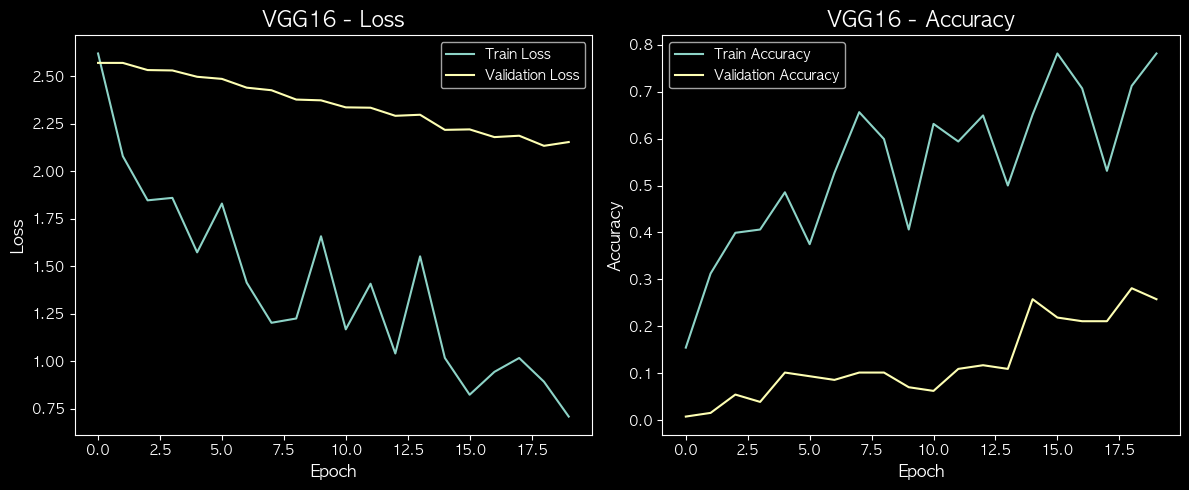

In [ ]:
# VGG16 Transfer Learning 모델 학습 및 평가
vgg_history, vgg_acc = train_and_evaluate_model(vgg_model, 'VGG16')

## <a id='toc2_8_'></a>[DenseNet121을 활용한 Transfer Learning](#toc0_)

In [20]:
# DenseNet121 Transfer Learning 모델 생성
densenet_model = create_transfer_model('DenseNet121')
densenet_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,303,755 (27.86 MB)

 Trainable params: 265,739 (1.01 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.1861 - loss: 3.0559 - val_accuracy: 0.1406 - val_loss: 2.5037 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.4375 - loss: 2.0360 - val_accuracy: 0.1562 - val_loss: 2.5173 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4416 - loss: 1.7742 - val_accuracy: 0.2266 - val_loss: 2.4266 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - accuracy: 0.5938 - loss: 1.1283 - val_accuracy: 0.1953 - val_loss: 2.4536 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5501 - loss: 1.3556 - val_accuracy: 0.2266 - val_loss: 2.3527 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.6250 - loss: 1.0286 - val_accuracy: 0.2109 - val_loss: 2.2837 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5965 - loss: 1.1408 - val_accu

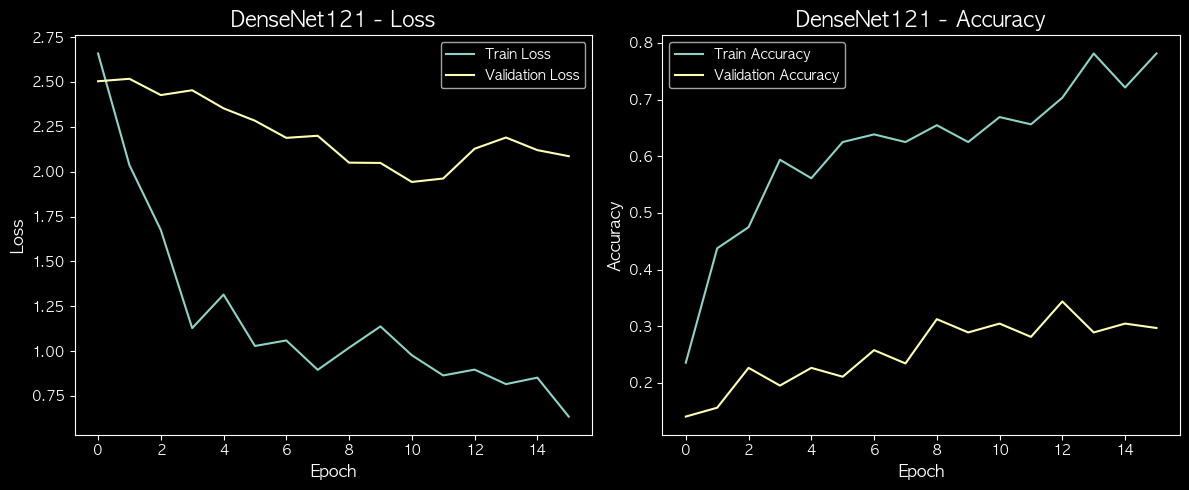

In [ ]:
# DenseNet121 Transfer Learning 모델 학습 및 평가
densenet_history, densenet_acc = train_and_evaluate_model(densenet_model, 'DenseNet121')

## <a id='toc2_9_'></a>[EfficientNetB0을 활용한 Transfer Learning](#toc0_)

In [22]:
# EfficientNetB0 Transfer Learning 모델 생성
efficientnet_model = create_transfer_model('EfficientNetB0')
efficientnet_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,381,358 (16.71 MB)

 Trainable params: 331,275 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.0821 - loss: 2.8025 - val_accuracy: 0.0938 - val_loss: 2.5230 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.2500 - loss: 2.5340 - val_accuracy: 0.0938 - val_loss: 2.5144 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.0874 - loss: 2.7533 - val_accuracy: 0.1016 - val_loss: 2.4511 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.1250 - loss: 2.7782 - val_accuracy: 0.1016 - val_loss: 2.4554 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.1048 - loss: 2.7110 - val_accuracy: 0.1016 - val_loss: 2.5456 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.0625 - loss: 2.9538 - val_accuracy: 0.1016 - val_loss: 2.5531 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.1123 - loss: 2.7378 - val_accu

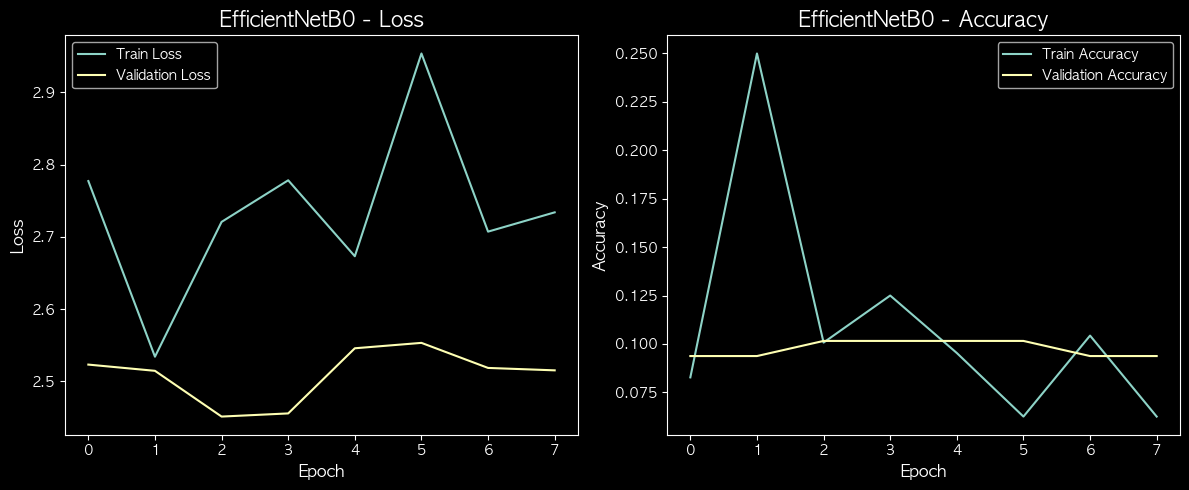

In [ ]:
# EfficientNetB0 Transfer Learning 모델 학습 및 평가
efficientnet_history, efficientnet_acc = train_and_evaluate_model(efficientnet_model, 'EfficientNetB0')

## <a id='toc2_10_'></a>[MobileNetV2를 활용한 Transfer Learning](#toc0_)

In [24]:
# MobileNetV2 Transfer Learning 모델 생성
mobilenet_model = create_transfer_model('MobileNetV2')
mobilenet_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,771 (9.88 MB)

 Trainable params: 331,275 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2130 - loss: 2.8344 - val_accuracy: 0.2031 - val_loss: 2.4279 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.5312 - loss: 1.5901 - val_accuracy: 0.2266 - val_loss: 2.3526 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5568 - loss: 1.4174 - val_accuracy: 0.2031 - val_loss: 2.1992 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.5000 - loss: 1.4319 - val_accuracy: 0.2734 - val_loss: 2.2079 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6164 - loss: 1.0782 - val_accuracy: 0.2656 - val_loss: 2.0915 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.9167 - loss: 0.5974 - val_accuracy: 0.2266 - val_loss: 2.0940 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6842 - loss: 0.9767 - val_accu

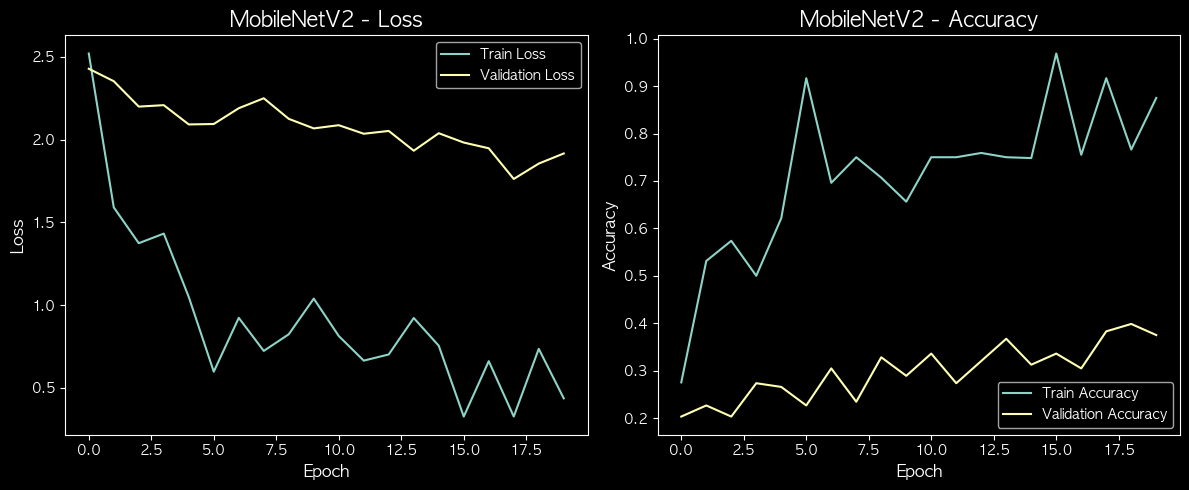

In [ ]:
# MobileNetV2 Transfer Learning 모델 학습 및 평가
mobilenet_history, mobilenet_acc = train_and_evaluate_model(mobilenet_model, 'MobileNetV2')

## <a id='toc2_11_'></a>[Fine-Tuning을 통한 성능 향상 (최고 성능 모델)](#toc0_)

In [26]:
# 최고 성능 모델 선택 (여기서는 EfficientNetB0 가정)
def create_fine_tuned_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(classes)):
    # 베이스 모델 로드
    base_model = applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # 상위 레이어 해제하여 학습 가능하게 설정
    base_model.trainable = True
    
    # 처음 100개 레이어는 고정
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # 모델 구성
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # 모델 컴파일 (낮은 학습률 사용)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [27]:
# Fine-Tuned 모델 생성
fine_tuned_model = create_fine_tuned_model()
fine_tuned_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,381,358 (16.71 MB)

 Trainable params: 4,171,623 (15.91 MB)

 Non-trainable params: 209,735 (819.28 KB)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.1022 - loss: 3.7766 - val_accuracy: 0.0000e+00 - val_loss: 2.4381 - learning_rate: 1.0000e-05
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.0938 - loss: 3.7268 - val_accuracy: 0.0000e+00 - val_loss: 2.4381 - learning_rate: 1.0000e-05
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.0928 - loss: 3.3937 - val_accuracy: 0.1016 - val_loss: 2.4383 - learning_rate: 1.0000e-05
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.0625 - loss: 3.4637 - val_accuracy: 0.1016 - val_loss: 2.4386 - learning_rate: 1.0000e-05
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.0716 - loss: 3.6821 - val_accuracy: 0.1016 - val_loss: 2.4438 - learning_rate: 2.0000e-06
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.2500 - loss: 2.6555 - val_accuracy: 0.1016 - val_loss: 2.4440 - learning_rate: 2.0000e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - l

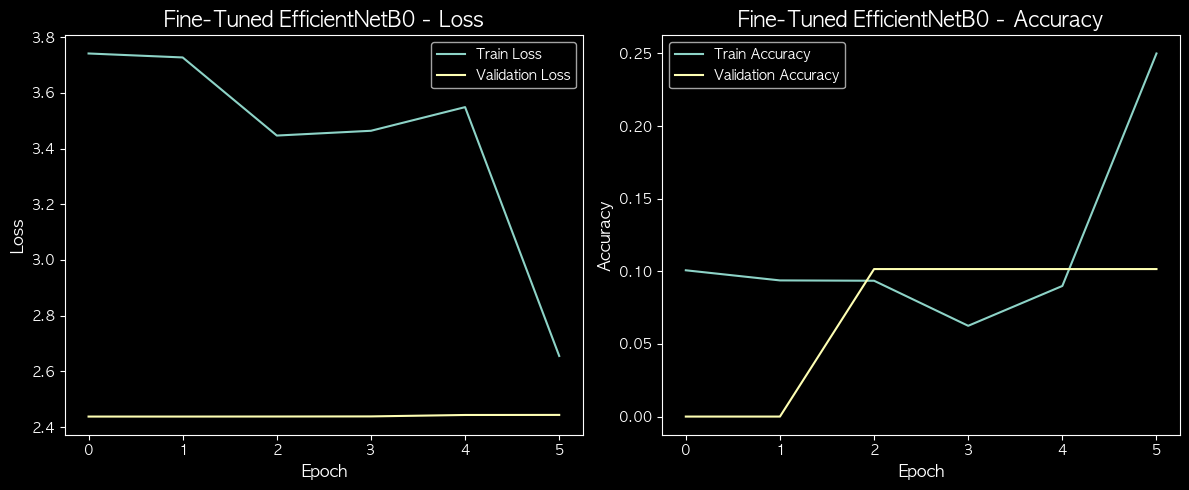

In [ ]:
# Fine-Tuned 모델 학습 및 평가
fine_tuned_history, fine_tuned_acc = train_and_evaluate_model(fine_tuned_model, 'Fine-Tuned EfficientNetB0', epochs=15)

## <a id='toc2_12_'></a>[모델 성능 비교 및 결과 정리](#toc0_)

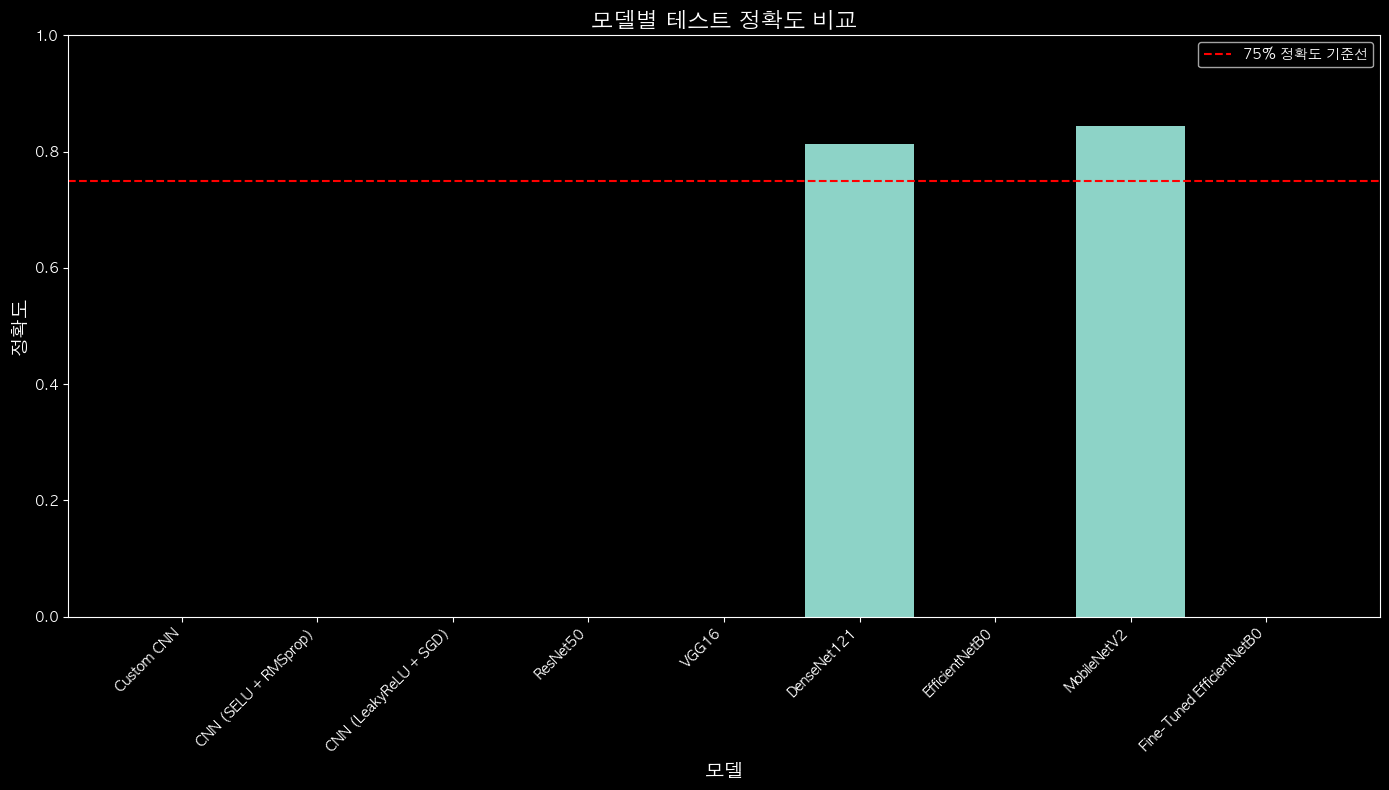

,모델,테스트 정확도,정확도 > 75%
7,MobileNetV2,0.8438,True
5,DenseNet121,0.8125,True
0,Custom CNN,0.0000,False
1,CNN (SELU + RMSprop),0.0000,False
2,CNN (LeakyReLU + SGD),0.0000,False
3,ResNet50,0.0000,False
4,VGG16,0.0000,False
6,EfficientNetB0,0.0000,False
8,Fine-Tuned EfficientNetB0,0.0000,False


In [ ]:
# 모든 모델의 테스트 정확도 저장
model_accuracies = {
    'Custom CNN': custom_cnn_acc,
    'CNN (SELU + RMSprop)': cnn_selu_rmsprop_acc,
    'CNN (LeakyReLU + SGD)': cnn_leakyrelu_sgd_acc,
    'ResNet50': resnet_acc,
    'VGG16': vgg_acc,
    'DenseNet121': densenet_acc,
    'EfficientNetB0': efficientnet_acc,
    'MobileNetV2': mobilenet_acc,
    'Fine-Tuned EfficientNetB0': fine_tuned_acc
}

# 모델 성능 비교 시각화
plt.figure(figsize=(14, 8))
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.title('모델별 테스트 정확도 비교', fontsize=16)
plt.xlabel('모델', fontsize=14)
plt.ylabel('정확도', fontsize=14)
plt.ylim(0, 1.0)
plt.axhline(y=0.75, color='r', linestyle='--', label='75% 정확도 기준선')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# 결과 표로 출력
results_df = pd.DataFrame({
    '모델': list(model_accuracies.keys()),
    '테스트 정확도': [f'{acc:.4f}' for acc in model_accuracies.values()],
    '정확도 > 75%': [acc > 0.75 for acc in model_accuracies.values()]
})
results_df.sort_values('테스트 정확도', ascending=False)

# <a id='toc3_'></a>[Pytorch](#toc0_)

In [30]:
# PyTorch 필요 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import functional as F

# GPU 사용 가능 여부 확인
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch 버전: {torch.__version__}")
print(f"사용 장치: {device}")

# 랜덤 시드 설정
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

PyTorch 버전: 2.6.0
사용 장치: mps


In [31]:
# 커스텀 수화 이미지 데이터셋 클래스
class SignLanguageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.image_paths = []
        self.labels = []
        
        # 이미지 경로와 라벨 수집
        for cls in self.classes:
            class_path = os.path.join(root_dir, cls)
            class_idx = self.class_to_idx[cls]
            
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.image_paths.append(img_path)
                self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"이미지 로딩 오류 {img_path}: {e}")
            # 오류 발생 시 대체 이미지 반환
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [38]:
# 학습/검증/테스트 데이터 변환 설정
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 전체 학습 데이터셋
full_train_dataset = SignLanguageDataset(root_dir=TRAIN_DIR, transform=train_transform)

# 학습/검증 데이터 분할
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_train_dataset, [train_size, val_size]
)

# 테스트 데이터셋
test_dataset = SignLanguageDataset(root_dir=TEST_DIR, transform=val_test_transform)

# 데이터 로더 정의
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 데이터셋 정보 출력
print(f'학습 데이터 수: {len(train_dataset)}')
print(f'검증 데이터 수: {len(val_dataset)}')
print(f'테스트 데이터 수: {len(test_dataset)}')
print(f'클래스 수: {len(full_train_dataset.classes)}')

학습 데이터 수: 621
검증 데이터 수: 156
테스트 데이터 수: 330
클래스 수: 11


In [ ]:
# 학습 함수
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 그라디언트 초기화
        optimizer.zero_grad()
        
        # 순전파
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        # 통계 기록
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.float() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc.item()

# 검증/테스트 함수
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.float() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc.item()

# 모델 학습 및 평가 관리 함수
def train_and_evaluate_pytorch_model(model, model_name, train_loader, val_loader, test_loader, 
                                    device, num_epochs=20, patience=5):
    # 손실 함수 및 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6)
    
    # 학습 히스토리 저장
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    # 최고 성능 모델 저장 변수
    best_val_loss = float('inf')
    best_model_wts = model.state_dict()
    best_epoch = 0
    no_improve_epochs = 0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # 학습
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # 검증
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        # 학습률 스케줄러 업데이트
        scheduler.step(val_loss)
        
        # 히스토리 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.7f}")
        
        # 최고 성능 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict().copy()
            best_epoch = epoch
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
        
        # 조기 종료
        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # 최고 성능 모델 복원
    model.load_state_dict(best_model_wts)
    print(f"Best model from epoch {best_epoch+1} restored")
    
    # 테스트 평가
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"\n{model_name} - 테스트 정확도: {test_acc:.4f}")
    
    # 학습 결과 시각화
    plot_pytorch_history(history, model_name)
    
    return history, test_acc

# 학습 결과 시각화 함수
def plot_pytorch_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    
    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy', fontsize=15)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## <a id='toc3_1_'></a>[PyTorch CNN 모델 구현](#toc0_)

In [44]:
# PyTorch 커스텀 CNN 모델 정의
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # 첫 번째 컨볼루션 블록
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )
        
        # 두 번째 컨볼루션 블록
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )
        
        # 세 번째 컨볼루션 블록
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )
        
        # 네 번째 컨볼루션 블록
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )
        
        # 분류기
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * (IMG_SIZE // 16) * (IMG_SIZE // 16), 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.classifier(x)
        return x

In [45]:
# PyTorch 커스텀 CNN 모델 생성 및 학습
pytorch_custom_cnn = CustomCNN(num_classes=len(full_train_dataset.classes)).to(device)
print(pytorch_custom_cnn)


CustomCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, pa

Epoch 1/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.6376, Train Acc: 0.1111
Val Loss: 2.4869, Val Acc: 0.0897
Current LR: 0.0010000
Epoch 2/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.5305, Train Acc: 0.1208
Val Loss: 2.5649, Val Acc: 0.0897
Current LR: 0.0010000
Epoch 3/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.4697, Train Acc: 0.1079
Val Loss: 2.4609, Val Acc: 0.0833
Current LR: 0.0010000
Epoch 4/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.4287, Train Acc: 0.1353
Val Loss: 2.3966, Val Acc: 0.1474
Current LR: 0.0010000
Epoch 5/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.4153, Train Acc: 0.1288
Val Loss: 2.3230, Val Acc: 0.1987
Current LR: 0.0010000
Epoch 6/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.4307, Train Acc: 0.1272
Val Loss: 2.3720, Val Acc: 0.1282
Current LR: 0.0010000
Epoch 7/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.4158, Train Acc: 0.1337
Val Loss: 2.3145, Val Acc: 0.1410
Current LR: 0.0010000
Epoch 8/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.4013, Train Acc: 0.1320
Val Loss: 2.2904, Val Acc: 0.1859
Current LR: 0.0010000
Epoch 9/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.4062, Train Acc: 0.1353
Val Loss: 2.2684, Val Acc: 0.1923
Current LR: 0.0010000
Epoch 10/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.3439, Train Acc: 0.1514
Val Loss: 2.2545, Val Acc: 0.1923
Current LR: 0.0010000
Epoch 11/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.2949, Train Acc: 0.1755
Val Loss: 2.4551, Val Acc: 0.1667
Current LR: 0.0010000
Epoch 12/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.2639, Train Acc: 0.2126
Val Loss: 2.1904, Val Acc: 0.1923
Current LR: 0.0010000
Epoch 13/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.2785, Train Acc: 0.1755
Val Loss: 2.2018, Val Acc: 0.1795
Current LR: 0.0010000
Epoch 14/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.2103, Train Acc: 0.2110
Val Loss: 2.1813, Val Acc: 0.2115
Current LR: 0.0010000
Epoch 15/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.1892, Train Acc: 0.2110
Val Loss: 2.1928, Val Acc: 0.1667
Current LR: 0.0010000
Epoch 16/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.2141, Train Acc: 0.1884
Val Loss: 2.3713, Val Acc: 0.1538
Current LR: 0.0010000
Epoch 17/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.2078, Train Acc: 0.2303
Val Loss: 2.2050, Val Acc: 0.1795
Current LR: 0.0010000
Epoch 18/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.1764, Train Acc: 0.2045
Val Loss: 2.2117, Val Acc: 0.2115
Current LR: 0.0002000
Epoch 19/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.1804, Train Acc: 0.2206
Val Loss: 2.0911, Val Acc: 0.2244
Current LR: 0.0002000
Epoch 20/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.0444, Train Acc: 0.2560
Val Loss: 2.0440, Val Acc: 0.2436
Current LR: 0.0002000
Best model from epoch 20 restored


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]


PyTorch Custom CNN - 테스트 정확도: 0.1333


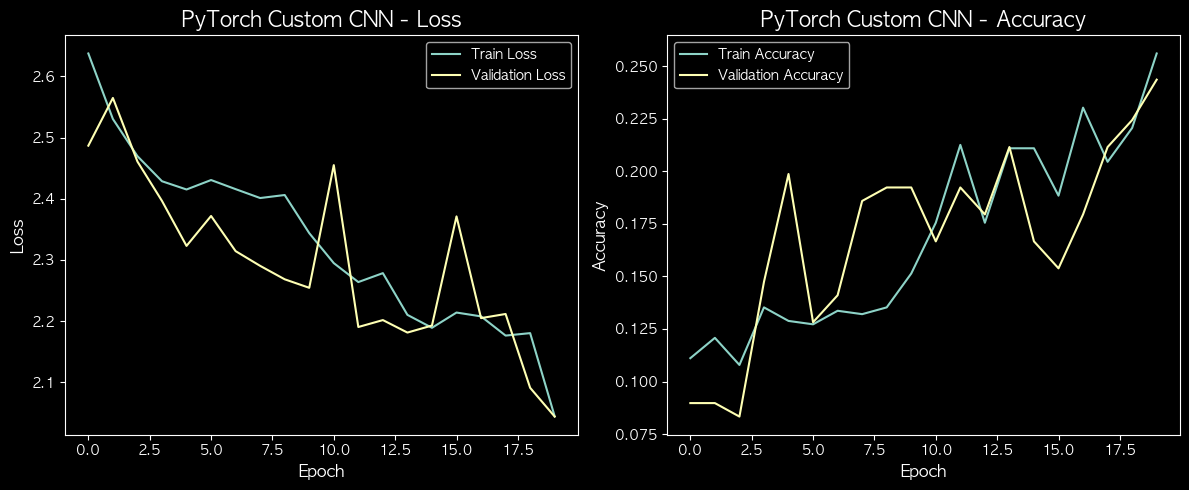

In [ ]:

# 모델 학습 및 평가
pytorch_custom_cnn_history, pytorch_custom_cnn_acc = train_and_evaluate_pytorch_model(
    pytorch_custom_cnn, 'PyTorch Custom CNN', 
    train_loader, val_loader, test_loader, device
)

## <a id='toc3_2_'></a>[PyTorch ResNet50 Transfer Learning](#toc0_)

In [47]:
# PyTorch ResNet50 Transfer Learning 모델 정의
def create_pytorch_transfer_model(base_model_name, num_classes):
    if base_model_name == 'ResNet50':
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    elif base_model_name == 'VGG16':
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    elif base_model_name == 'DenseNet121':
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
    elif base_model_name == 'EfficientNetB0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    else:
        raise ValueError(f"지원하지 않는 모델: {base_model_name}")
    
    # 마지막 레이어 제외하고 가중치 고정
    for param in model.parameters():
        param.requires_grad = False
    
    # 모델별 분류기 헤드 수정
    if base_model_name == 'ResNet50':
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    elif base_model_name == 'VGG16':
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    elif base_model_name == 'DenseNet121':
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    elif base_model_name == 'EfficientNetB0':
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    return model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/syshin/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 60.7MB/s]


Epoch 1/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.9587, Train Acc: 0.3527
Val Loss: 1.6322, Val Acc: 0.5128
Current LR: 0.0010000
Epoch 2/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.3684, Train Acc: 0.6006
Val Loss: 1.2653, Val Acc: 0.6346
Current LR: 0.0010000
Epoch 3/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.1826, Train Acc: 0.6361
Val Loss: 1.2791, Val Acc: 0.5513
Current LR: 0.0010000
Epoch 4/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0472, Train Acc: 0.6699
Val Loss: 1.0433, Val Acc: 0.6667
Current LR: 0.0010000
Epoch 5/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9849, Train Acc: 0.6618
Val Loss: 1.0012, Val Acc: 0.6731
Current LR: 0.0010000
Epoch 6/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9053, Train Acc: 0.6973
Val Loss: 1.0007, Val Acc: 0.6923
Current LR: 0.0010000
Epoch 7/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8340, Train Acc: 0.7295
Val Loss: 0.9211, Val Acc: 0.6603
Current LR: 0.0010000
Epoch 8/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7748, Train Acc: 0.7472
Val Loss: 0.9071, Val Acc: 0.6923
Current LR: 0.0010000
Epoch 9/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7388, Train Acc: 0.7601
Val Loss: 0.8738, Val Acc: 0.6603
Current LR: 0.0010000
Epoch 10/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7447, Train Acc: 0.7440
Val Loss: 0.8767, Val Acc: 0.6987
Current LR: 0.0010000
Epoch 11/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7412, Train Acc: 0.7536
Val Loss: 0.8141, Val Acc: 0.7115
Current LR: 0.0010000
Epoch 12/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7141, Train Acc: 0.7601
Val Loss: 0.8314, Val Acc: 0.7179
Current LR: 0.0010000
Epoch 13/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6803, Train Acc: 0.7681
Val Loss: 0.8356, Val Acc: 0.6538
Current LR: 0.0010000
Epoch 14/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6353, Train Acc: 0.7890
Val Loss: 0.7971, Val Acc: 0.7115
Current LR: 0.0010000
Epoch 15/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6184, Train Acc: 0.7923
Val Loss: 0.7959, Val Acc: 0.7308
Current LR: 0.0010000
Epoch 16/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6234, Train Acc: 0.7713
Val Loss: 0.8195, Val Acc: 0.6795
Current LR: 0.0010000
Epoch 17/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6253, Train Acc: 0.7874
Val Loss: 0.7695, Val Acc: 0.7308
Current LR: 0.0010000
Epoch 18/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.5882, Train Acc: 0.7971
Val Loss: 0.7505, Val Acc: 0.7500
Current LR: 0.0010000
Epoch 19/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6343, Train Acc: 0.7794
Val Loss: 0.6672, Val Acc: 0.7692
Current LR: 0.0010000
Epoch 20/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6403, Train Acc: 0.7713
Val Loss: 0.7029, Val Acc: 0.7500
Current LR: 0.0010000
Best model from epoch 19 restored


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]


PyTorch ResNet50 - 테스트 정확도: 0.5545


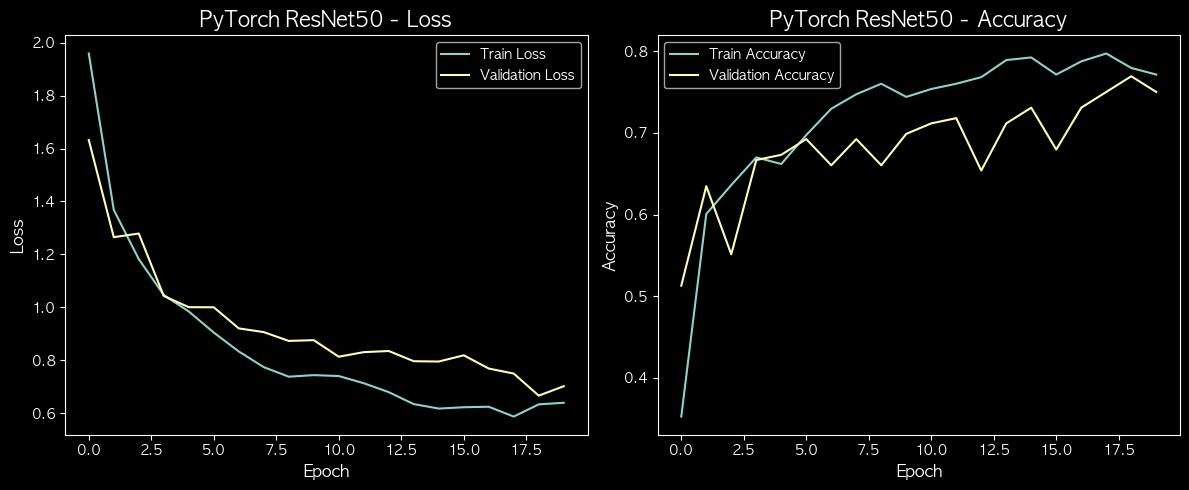

In [ ]:

# PyTorch ResNet50 모델 생성 및 학습
pytorch_resnet = create_pytorch_transfer_model('ResNet50', len(full_train_dataset.classes)).to(device)
pytorch_resnet_history, pytorch_resnet_acc = train_and_evaluate_pytorch_model(
    pytorch_resnet, 'PyTorch ResNet50', 
    train_loader, val_loader, test_loader, device
)

## <a id='toc3_3_'></a>[PyTorch Transfer Learning](#toc0_)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/syshin/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 61.1MB/s] 


Epoch 1/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.2610, Train Acc: 0.1932
Val Loss: 1.9657, Val Acc: 0.2885
Current LR: 0.0010000
Epoch 2/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.8562, Train Acc: 0.3655
Val Loss: 1.7573, Val Acc: 0.3974
Current LR: 0.0010000
Epoch 3/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.7019, Train Acc: 0.4026
Val Loss: 1.6081, Val Acc: 0.4679
Current LR: 0.0010000
Epoch 4/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.6022, Train Acc: 0.4573
Val Loss: 1.5477, Val Acc: 0.4423
Current LR: 0.0010000
Epoch 5/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.5444, Train Acc: 0.4589
Val Loss: 1.5198, Val Acc: 0.4808
Current LR: 0.0010000
Epoch 6/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.5012, Train Acc: 0.4686
Val Loss: 1.4860, Val Acc: 0.5000
Current LR: 0.0010000
Epoch 7/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.4670, Train Acc: 0.5072
Val Loss: 1.3608, Val Acc: 0.5385
Current LR: 0.0010000
Epoch 8/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.4571, Train Acc: 0.4992
Val Loss: 1.4192, Val Acc: 0.4744
Current LR: 0.0010000
Epoch 9/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.3890, Train Acc: 0.5008
Val Loss: 1.2646, Val Acc: 0.5577
Current LR: 0.0010000
Epoch 10/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.3175, Train Acc: 0.5346
Val Loss: 1.2882, Val Acc: 0.6026
Current LR: 0.0010000
Epoch 11/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.3374, Train Acc: 0.5266
Val Loss: 1.2746, Val Acc: 0.5192
Current LR: 0.0010000
Epoch 12/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.3288, Train Acc: 0.5298
Val Loss: 1.1545, Val Acc: 0.6090
Current LR: 0.0010000
Epoch 13/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2944, Train Acc: 0.5411
Val Loss: 1.2056, Val Acc: 0.6026
Current LR: 0.0010000
Epoch 14/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.3321, Train Acc: 0.5266
Val Loss: 1.1952, Val Acc: 0.6090
Current LR: 0.0010000
Epoch 15/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2947, Train Acc: 0.5411
Val Loss: 1.1490, Val Acc: 0.5833
Current LR: 0.0010000
Epoch 16/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2322, Train Acc: 0.5572
Val Loss: 1.1728, Val Acc: 0.5641
Current LR: 0.0010000
Epoch 17/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2103, Train Acc: 0.5733
Val Loss: 1.1682, Val Acc: 0.5833
Current LR: 0.0010000
Epoch 18/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2290, Train Acc: 0.5668
Val Loss: 1.1978, Val Acc: 0.5641
Current LR: 0.0010000
Epoch 19/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2582, Train Acc: 0.5507
Val Loss: 1.0837, Val Acc: 0.6282
Current LR: 0.0010000
Epoch 20/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2412, Train Acc: 0.5443
Val Loss: 1.1217, Val Acc: 0.6090
Current LR: 0.0010000
Best model from epoch 19 restored


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]


PyTorch VGG16 - 테스트 정확도: 0.3515


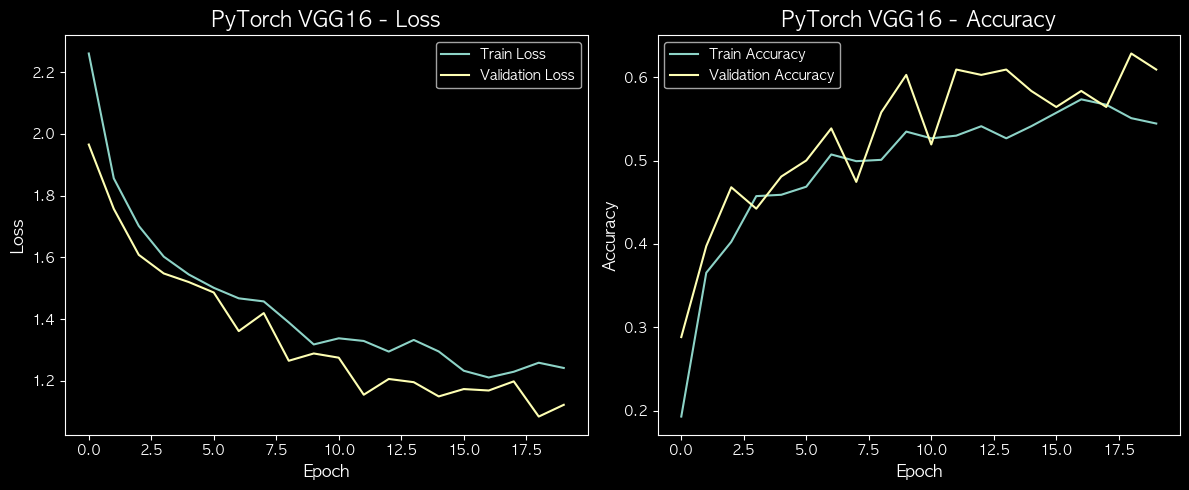

In [49]:
# PyTorch VGG16 모델 생성 및 학습
pytorch_vgg = create_pytorch_transfer_model('VGG16', len(full_train_dataset.classes)).to(device)
pytorch_vgg_history, pytorch_vgg_acc = train_and_evaluate_pytorch_model(
    pytorch_vgg, 'PyTorch VGG16', 
    train_loader, val_loader, test_loader, device
)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/syshin/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 58.8MB/s]


Epoch 1/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.1611, Train Acc: 0.2576
Val Loss: 1.8475, Val Acc: 0.3846
Current LR: 0.0010000
Epoch 2/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.5066, Train Acc: 0.5266
Val Loss: 1.4110, Val Acc: 0.5641
Current LR: 0.0010000
Epoch 3/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2651, Train Acc: 0.5974
Val Loss: 1.2149, Val Acc: 0.6282
Current LR: 0.0010000
Epoch 4/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0439, Train Acc: 0.6908
Val Loss: 1.0558, Val Acc: 0.7115
Current LR: 0.0010000
Epoch 5/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9536, Train Acc: 0.7150
Val Loss: 0.9499, Val Acc: 0.7308
Current LR: 0.0010000
Epoch 6/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8617, Train Acc: 0.7279
Val Loss: 0.8819, Val Acc: 0.7179
Current LR: 0.0010000
Epoch 7/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7790, Train Acc: 0.7601
Val Loss: 0.8303, Val Acc: 0.7179
Current LR: 0.0010000
Epoch 8/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7200, Train Acc: 0.7874
Val Loss: 0.7908, Val Acc: 0.7308
Current LR: 0.0010000
Epoch 9/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6919, Train Acc: 0.7890
Val Loss: 0.8542, Val Acc: 0.7372
Current LR: 0.0010000
Epoch 10/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6024, Train Acc: 0.8196
Val Loss: 0.7759, Val Acc: 0.7244
Current LR: 0.0010000
Epoch 11/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6551, Train Acc: 0.7858
Val Loss: 0.7711, Val Acc: 0.7372
Current LR: 0.0010000
Epoch 12/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.5996, Train Acc: 0.8003
Val Loss: 0.7292, Val Acc: 0.7372
Current LR: 0.0010000
Epoch 13/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.5727, Train Acc: 0.8277
Val Loss: 0.6942, Val Acc: 0.7500
Current LR: 0.0010000
Epoch 14/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.5250, Train Acc: 0.8454
Val Loss: 0.8356, Val Acc: 0.7372
Current LR: 0.0010000
Epoch 15/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.5654, Train Acc: 0.8261
Val Loss: 0.7078, Val Acc: 0.7692
Current LR: 0.0010000
Epoch 16/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.5296, Train Acc: 0.8084
Val Loss: 0.6784, Val Acc: 0.7885
Current LR: 0.0010000
Epoch 17/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.5278, Train Acc: 0.8229
Val Loss: 0.7408, Val Acc: 0.7051
Current LR: 0.0010000
Epoch 18/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.5001, Train Acc: 0.8325
Val Loss: 0.7175, Val Acc: 0.7564
Current LR: 0.0010000
Epoch 19/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.4995, Train Acc: 0.8422
Val Loss: 0.7041, Val Acc: 0.7692
Current LR: 0.0010000
Epoch 20/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.5054, Train Acc: 0.8116
Val Loss: 0.6506, Val Acc: 0.7885
Current LR: 0.0010000
Best model from epoch 20 restored


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]


PyTorch DenseNet121 - 테스트 정확도: 0.5061


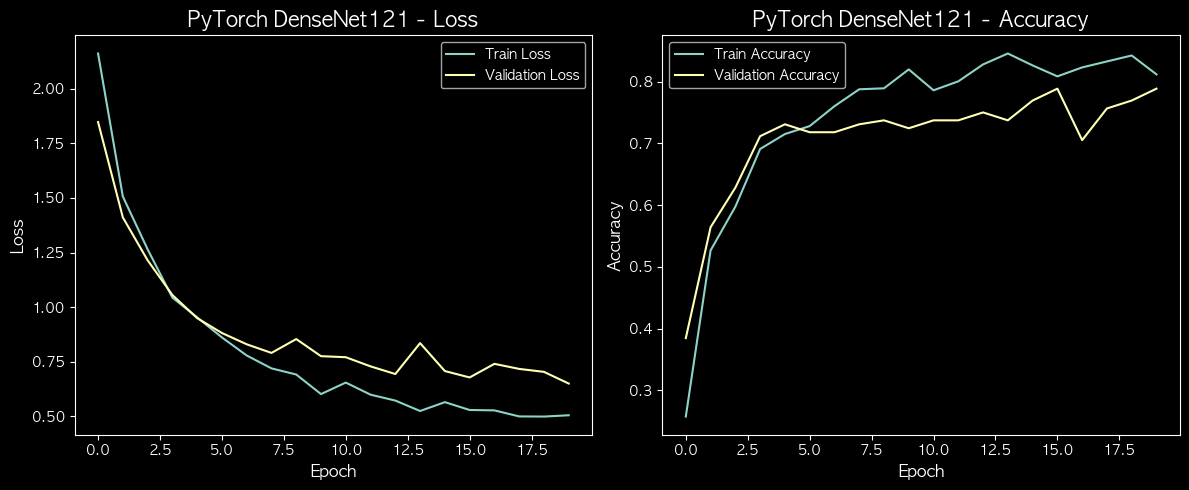

In [50]:
# PyTorch DenseNet121 모델 생성 및 학습
pytorch_densenet = create_pytorch_transfer_model('DenseNet121', len(full_train_dataset.classes)).to(device)
pytorch_densenet_history, pytorch_densenet_acc = train_and_evaluate_pytorch_model(
    pytorch_densenet, 'PyTorch DenseNet121', 
    train_loader, val_loader, test_loader, device
)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/syshin/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 51.5MB/s]


Epoch 1/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 2.1593, Train Acc: 0.2609
Val Loss: 1.8934, Val Acc: 0.3846
Current LR: 0.0010000
Epoch 2/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.6466, Train Acc: 0.4847
Val Loss: 1.4223, Val Acc: 0.5256
Current LR: 0.0010000
Epoch 3/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.3615, Train Acc: 0.5926
Val Loss: 1.2565, Val Acc: 0.5513
Current LR: 0.0010000
Epoch 4/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.2282, Train Acc: 0.5958
Val Loss: 1.1977, Val Acc: 0.6346
Current LR: 0.0010000
Epoch 5/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.1141, Train Acc: 0.6586
Val Loss: 1.1041, Val Acc: 0.6026
Current LR: 0.0010000
Epoch 6/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 1.0310, Train Acc: 0.6731
Val Loss: 1.0334, Val Acc: 0.6795
Current LR: 0.0010000
Epoch 7/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9833, Train Acc: 0.6908
Val Loss: 1.0259, Val Acc: 0.6410
Current LR: 0.0010000
Epoch 8/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8985, Train Acc: 0.7069
Val Loss: 0.9433, Val Acc: 0.6603
Current LR: 0.0010000
Epoch 9/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9117, Train Acc: 0.6812
Val Loss: 0.9407, Val Acc: 0.6603
Current LR: 0.0010000
Epoch 10/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8390, Train Acc: 0.7118
Val Loss: 0.8520, Val Acc: 0.7372
Current LR: 0.0010000
Epoch 11/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8249, Train Acc: 0.7311
Val Loss: 0.8963, Val Acc: 0.6859
Current LR: 0.0010000
Epoch 12/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8125, Train Acc: 0.7343
Val Loss: 0.8904, Val Acc: 0.6987
Current LR: 0.0010000
Epoch 13/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8412, Train Acc: 0.7053
Val Loss: 0.7926, Val Acc: 0.7308
Current LR: 0.0010000
Epoch 14/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8146, Train Acc: 0.7085
Val Loss: 0.7531, Val Acc: 0.7244
Current LR: 0.0010000
Epoch 15/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.8031, Train Acc: 0.7166
Val Loss: 0.9173, Val Acc: 0.6795
Current LR: 0.0010000
Epoch 16/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7193, Train Acc: 0.7440
Val Loss: 0.8802, Val Acc: 0.6859
Current LR: 0.0010000
Epoch 17/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7125, Train Acc: 0.7488
Val Loss: 0.8364, Val Acc: 0.6923
Current LR: 0.0010000
Epoch 18/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.7175, Train Acc: 0.7681
Val Loss: 0.7801, Val Acc: 0.6987
Current LR: 0.0002000
Epoch 19/20


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6910, Train Acc: 0.7536
Val Loss: 0.7944, Val Acc: 0.6923
Current LR: 0.0002000
Early stopping at epoch 19
Best model from epoch 14 restored


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]


PyTorch EfficientNet-B0 - 테스트 정확도: 0.5939


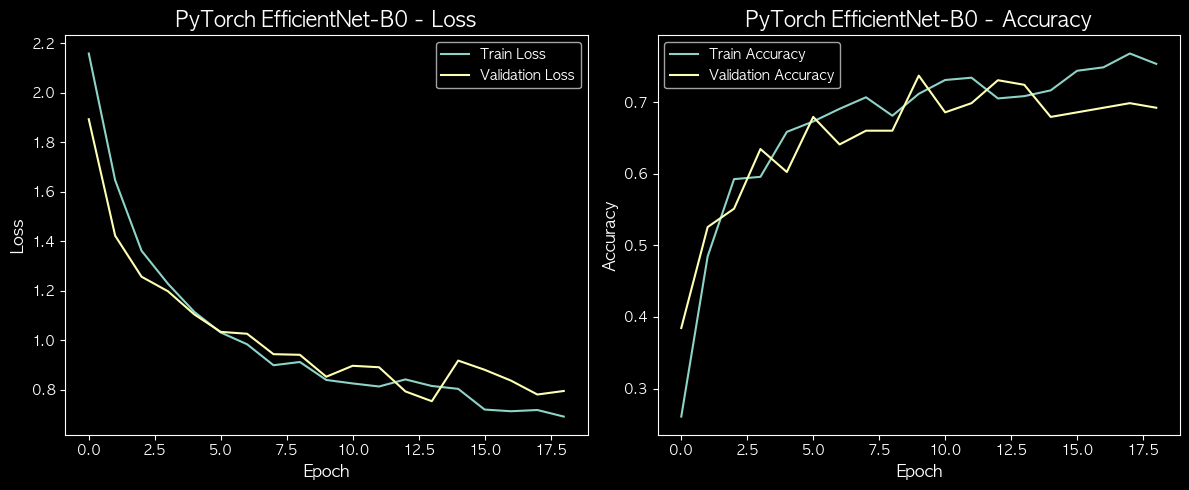

In [ ]:

# PyTorch EfficientNet-B0 모델 생성 및 학습
pytorch_efficientnet = create_pytorch_transfer_model('EfficientNetB0', len(full_train_dataset.classes)).to(device)
pytorch_efficientnet_history, pytorch_efficientnet_acc = train_and_evaluate_pytorch_model(
    pytorch_efficientnet, 'PyTorch EfficientNet-B0', 
    train_loader, val_loader, test_loader, device
)

# <a id='toc4_'></a>[결론](#toc0_)

## <a id='toc4_1_'></a>[결과 시각화](#toc0_)

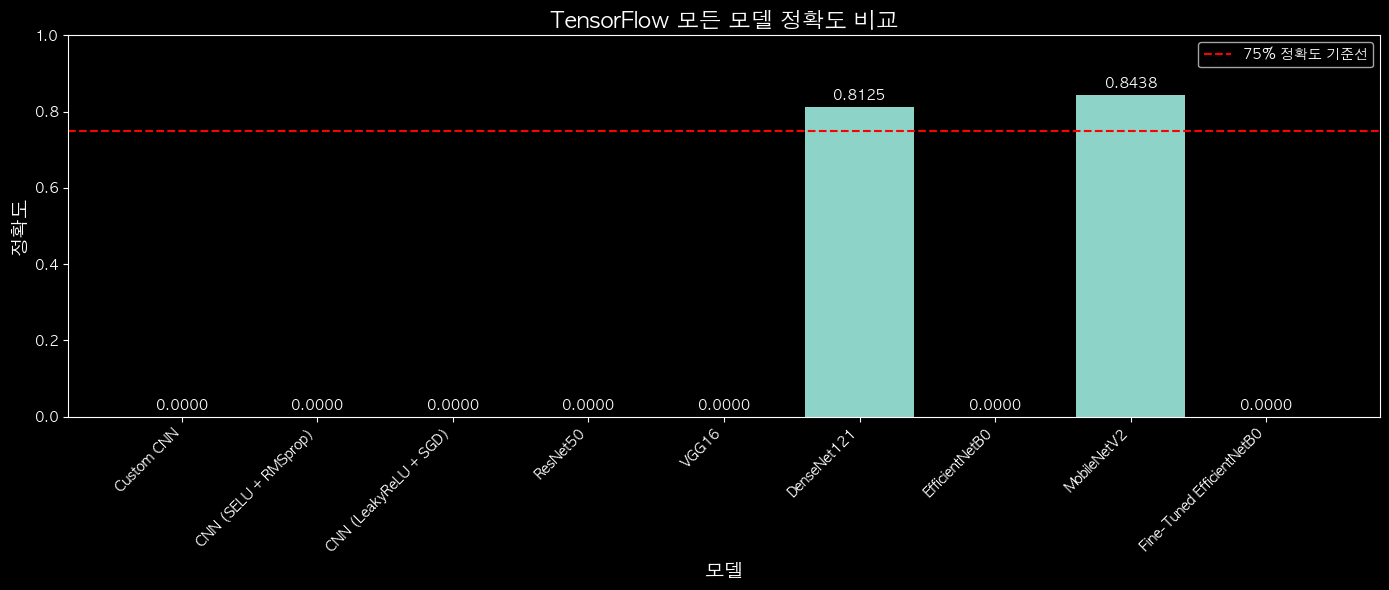

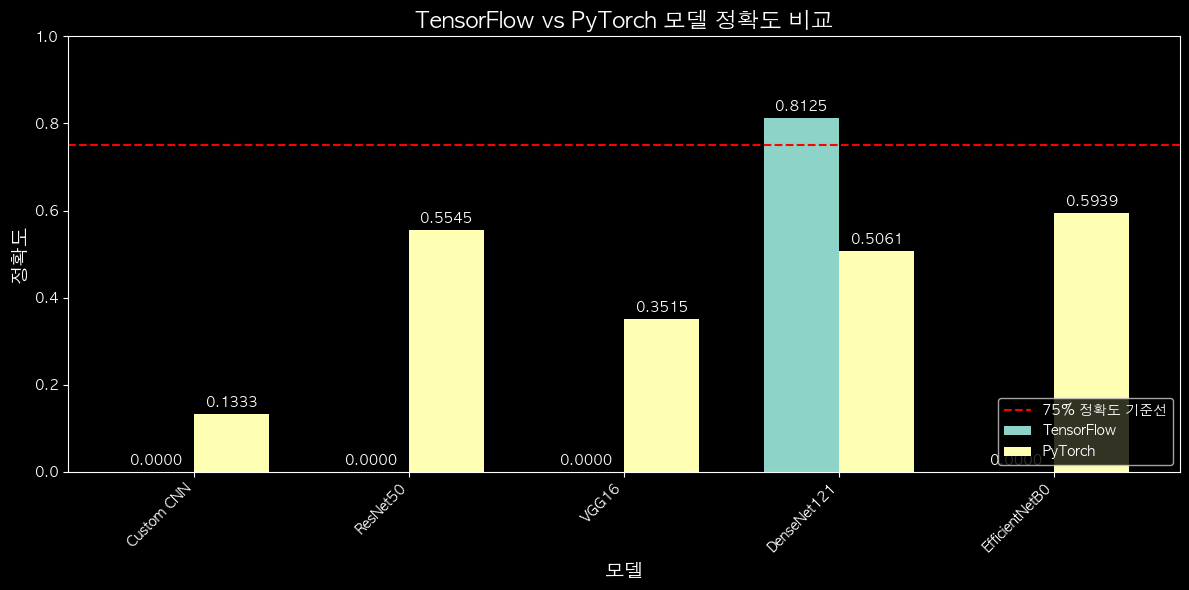

,모델,TensorFlow 정확도,PyTorch 정확도
0,Custom CNN,0.0000,0.1333
1,ResNet50,0.0000,0.5545
2,VGG16,0.0000,0.3515
3,DenseNet121,0.8125,0.5061
4,EfficientNetB0,0.0000,0.5939


In [ ]:
# PyTorch 모델의 테스트 정확도 저장
pytorch_model_accuracies = {
    'PyTorch Custom CNN': pytorch_custom_cnn_acc,
    'PyTorch ResNet50': pytorch_resnet_acc,
    'PyTorch VGG16': pytorch_vgg_acc,
    'PyTorch DenseNet121': pytorch_densenet_acc,
    'PyTorch EfficientNetB0': pytorch_efficientnet_acc
}

# TensorFlow 모델의 테스트 정확도 저장
model_accuracies = {
    'Custom CNN': custom_cnn_acc,
    'CNN (SELU + RMSprop)': cnn_selu_rmsprop_acc,
    'CNN (LeakyReLU + SGD)': cnn_leakyrelu_sgd_acc,
    'ResNet50': resnet_acc,
    'VGG16': vgg_acc,
    'DenseNet121': densenet_acc,
    'EfficientNetB0': efficientnet_acc,
    'MobileNetV2': mobilenet_acc,
    'Fine-Tuned EfficientNetB0': fine_tuned_acc
}

# TensorFlow & PyTorch 모델 비교를 위한 데이터 준비
tf_models = ['Custom CNN', 'CNN (SELU + RMSprop)', 'CNN (LeakyReLU + SGD)', 
             'ResNet50', 'VGG16', 'DenseNet121', 'EfficientNetB0', 'MobileNetV2', 
             'Fine-Tuned EfficientNetB0']
# PyTorch에는 일부 모델만 있으므로, 비교 가능한 모델만 선택
comparable_models = ['Custom CNN', 'ResNet50', 'VGG16', 'DenseNet121', 'EfficientNetB0']

# 시각화 1: 모든 TensorFlow 모델 정확도
plt.figure(figsize=(14, 6))
accuracies = [model_accuracies[model] for model in tf_models]
bars = plt.bar(tf_models, accuracies)
plt.axhline(y=0.75, color='r', linestyle='--', label='75% 정확도 기준선')
plt.title('TensorFlow 모든 모델 정확도 비교', fontsize=16)
plt.xlabel('모델', fontsize=14)
plt.ylabel('정확도', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend()

# 값 라벨 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 시각화 2: TensorFlow와 PyTorch 비교 가능한 모델 비교
x = np.arange(len(comparable_models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
tf_comparable_accs = [model_accuracies[model] for model in comparable_models]
pt_accs = [pytorch_model_accuracies[f'PyTorch {model}'] for model in comparable_models]

rects1 = ax.bar(x - width/2, tf_comparable_accs, width, label='TensorFlow')
rects2 = ax.bar(x + width/2, pt_accs, width, label='PyTorch')

ax.set_title('TensorFlow vs PyTorch 모델 정확도 비교', fontsize=16)
ax.set_xlabel('모델', fontsize=14)
ax.set_ylabel('정확도', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparable_models, rotation=45, ha='right')
ax.set_ylim(0, 1.0)
ax.axhline(y=0.75, color='r', linestyle='--', label='75% 정확도 기준선')
ax.legend(loc='lower right')

# 값 라벨 표시
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

# 모든 TensorFlow 모델 결과 테이블
tf_results_df = pd.DataFrame({
    '모델': tf_models,
    '정확도': [f'{model_accuracies[model]:.4f}' for model in tf_models],
    '75% 이상': [model_accuracies[model] >= 0.75 for model in tf_models]
})
tf_results_df.sort_values('정확도', ascending=False)

# TensorFlow vs PyTorch 비교 테이블
comparison_data = {
    '모델': comparable_models,
    'TensorFlow 정확도': [f'{model_accuracies[model]:.4f}' for model in comparable_models],
    'PyTorch 정확도': [f'{pytorch_model_accuracies[f"PyTorch {model}"]:.4f}' for model in comparable_models]
}
comparison_df = pd.DataFrame(comparison_data)
comparison_df

## <a id='toc4_2_'></a>[참고문헌](#toc0_)
- CNN: https://arxiv.org/abs/1511.08458
- DenseNet: https://arxiv.org/abs/1608.06993
- VGG16: https://arxiv.org/abs/1409.1556
- EfficientNet: https://arxiv.org/abs/1905.11946
- MobileNet: https://arxiv.org/abs/1704.04861